In [2]:
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

SyntaxError: invalid syntax (<ipython-input-2-505f186c0fce>, line 3)

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #print(objpoints, ', ', imgpoints)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

# Use cv2.calibrateCamera() and cv2.undistort()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
print(mtx, dist)
cv2.destroyAllWindows()

[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]]


In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [15]:
#Functions for Pipline

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    undist = np.copy(img)  # Delete this line
    return undist

# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    undist = np.copy(img)  # Delete this line
    return undist

#undistort the input image with the known parameter mtx and dist
def undistortImg(img, mtx, dist):
    imgUndistort = cv2.undistort(img, mtx, dist, None, mtx)
    return imgUndistort

#warp the preprocessed binary image
def warpImg(img,X,Y):

    src = np.float32([[(1-X)/2*img.shape[1],Y*img.shape[0]],[0,img.shape[0]],
                      [img.shape[1],img.shape[0]],[(1+X)/2*img.shape[1],Y*img.shape[0]]])
    print(img.shape)
    dst = np.float32([[0,0],[0,img.shape[0]],[img.shape[1],img.shape[0]],[img.shape[1],0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    #delete the next two lines
    return warped, M

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if (len(good_left_inds)>minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if (len(good_right_inds)>minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, left_fit, right_fit, ploty

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit_last, right_fit_last):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit_last[0]*nonzeroy**2 + left_fit_last[1]
    *nonzeroy + left_fit_last[2] - margin)) & (nonzerox < (left_fit_last[0]*nonzeroy
    **2 + left_fit_last[1]*nonzeroy + left_fit_last[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit_last[0]*nonzeroy**2 + right_fit_last[1]
    *nonzeroy + right_fit_last[2] - margin)) & (nonzerox < (right_fit_last[0]*nonzeroy
    **2 + right_fit_last[1]*nonzeroy + right_fit_last[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    if(len(leftx)<10000):
        left_fit = left_fit_last
        fLeftFound = False
    else:
        fLeftFound = True
        
    if(len(rightx)<10000):
        right_fit = right_fit_last
        fRightFound = False
    else:
        fRightFound = True
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, left_fit, right_fit, fLeftFound, fRightFound, ploty

In [14]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**1.5/2/np.abs(left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**1.5/2/np.abs(right_fit[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


In [4]:
# test distort
images = glob.glob('test_images/test1.jpg')
#img = cv2.imread(images[0])
#cv2.imshow('in', img)

#outimg = undistortImg(img, mtx, dist)
#cv2.imshow('out', outimg)
#print(image.shape)
img = cv2.imread(images[0])
warped, M = warpImg(img,0.17,0.65)
cv2.imshow('orig',img)
cv2.imshow('warped',warped)
cv2.destroyAllWindows()

(720, 1280, 3)


(720, 1280, 3)
[ 1.88296975e-04 -2.32682587e-01  3.15294671e+02] True


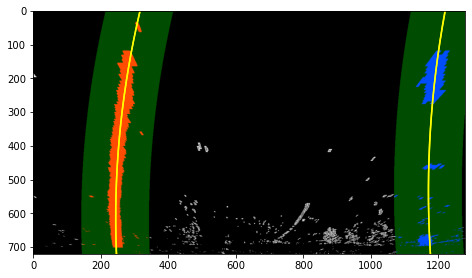

In [16]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!


image = mpimg.imread('test_images/test1.jpg')

result = pipeline(image)

# Plot the result
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()

#warp preprocessed
warped, M = warpImg(result,0.17,0.65)

#ax1.imshow(result)
#ax1.set_title('Original Image', fontsize=40)

#ax2.imshow(warped)
#ax2.set_title('Pipeline Result', fontsize=40)


cv2.imshow('warped',warped)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
out_img, left_fitx, right_fitx, left_fit, right_fit, ploty = fit_polynomial(warped)
#cv2.imshow("polynol", out_img)
#plt.imshow(out_img)

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

result, left_fitx, right_fitx, left_fit, right_fit, fLeftFound, fRightFound, ploty = search_around_poly(warped, left_fit, right_fit)
cv2.imshow("result",result)
print(left_fit, fLeftFound)

# View your output
plt.imshow(result)

In [20]:
def process_image(image):#, left_Line, right_Line):
    
    result = pipeline(image)
    warped, M = warpImg(result,0.17,0.65)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    #print(left_Line.recent_xfitted)

    if(left_Line.detected and right_Line.detected):
        print(1)
        result, left_fitx, right_fitx, left_fit, right_fit, fLeftFound, fRightFound, ploty = search_around_poly(warped, 
        left_Line.current_fit, right_Line.current_fit)
        left_Line.recent_xfitted = left_fitx
        right_Line.recent_xfitted = right_fitx
        
        left_Line.current_fit = left_fit
        right_Line.current_fit = right_fit
        
        left_Line.detected = fLeftFound
        right_Line.detected = fRightFound
        
        left_Line.radius_of_curvature, right_Line.radius_of_curvature = measure_curvature_pixels(ploty, left_fit, right_fit)
        
        
        
    else:
        result, left_fitx, right_fitx, left_fit, right_fit, ploty = fit_polynomial(warped)
        left_Line.recent_xfitted = left_fitx
        right_Line.recent_xfitted = right_fitx
        
        left_Line.current_fit = left_fit
        right_Line.current_fit = right_fit
        
        left_Line.detected = True
        right_Line.detected = True
        
        left_Line.radius_of_curvature, right_Line.radius_of_curvature = measure_curvature_pixels(ploty, left_fit, right_fit)
        print(2, len(left_fitx))
        #print(left_fit, right_fit)


    #plt.imshow(out_img)

    return result

(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)


TypeError: Expected Ptr<cv::UMat> for argument 'src'

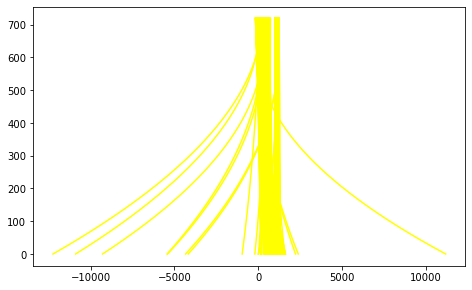

In [12]:
image = mpimg.imread('test_images/test1.jpg')

cap = cv2.VideoCapture('challenge_video.mp4')

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (1280,760))

left_Line = Line()
right_Line = Line()

while(cap.isOpened()):
    ret, image = cap.read()
    result = process_image(image)
    #out.write(result)

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()


t:   0%|                                                                             | 0/150 [00:00<?, ?it/s, now=None]

(720, 1280, 3)
2 720
Moviepy - Building video challenge_video_out.mp4.
Moviepy - Writing video challenge_video_out.mp4

(720, 1280, 3)
1
(720, 1280, 3)
1

t:   3%|██▎                                                                  | 5/150 [00:00<00:07, 18.15it/s, now=None]


(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1

t:   6%|████▏                                                                | 9/150 [00:00<00:08, 17.37it/s, now=None]


(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1


t:   7%|████▉                                                               | 11/150 [00:00<00:08, 16.91it/s, now=None]

(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1

t:  10%|██████▊                                                             | 15/150 [00:00<00:07, 17.19it/s, now=None]


(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1


t:  13%|████████▌                                                           | 19/150 [00:01<00:07, 17.23it/s, now=None]

(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1


t:  15%|██████████▍                                                         | 23/150 [00:01<00:07, 17.10it/s, now=None]

(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1


t:  18%|████████████▏                                                       | 27/150 [00:01<00:07, 17.18it/s, now=None]

(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)


t:  21%|██████████████                                                      | 31/150 [00:01<00:06, 17.60it/s, now=None]

1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1


t:  23%|███████████████▊                                                    | 35/150 [00:02<00:06, 18.05it/s, now=None]

(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1


t:  26%|█████████████████▋                                                  | 39/150 [00:02<00:06, 18.15it/s, now=None]

(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1


t:  29%|███████████████████▍                                                | 43/150 [00:02<00:05, 18.57it/s, now=None]

(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1


t:  30%|████████████████████▍                                               | 45/150 [00:02<00:05, 17.87it/s, now=None]

(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1

t:  33%|██████████████████████▏                                             | 49/150 [00:02<00:05, 17.57it/s, now=None]


(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1


t:  35%|████████████████████████                                            | 53/150 [00:03<00:05, 17.71it/s, now=None]

(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1
(720, 1280, 3)
1


t:  38%|█████████████████████████▊                                          | 57/150 [00:03<00:05, 18.48it/s, now=None]

(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)

t:  41%|███████████████████████████▋                                        | 61/150 [00:03<00:04, 18.79it/s, now=None]


1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720


t:  43%|█████████████████████████████▍                                      | 65/150 [00:03<00:04, 18.21it/s, now=None]

(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720


t:  46%|███████████████████████████████▎                                    | 69/150 [00:03<00:04, 18.49it/s, now=None]

(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)
2

t:  49%|█████████████████████████████████                                   | 73/150 [00:04<00:04, 18.23it/s, now=None]

 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  51%|██████████████████████████████████▉                                 | 77/150 [00:04<00:03, 18.31it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  54%|████████████████████████████████████▋                               | 81/150 [00:04<00:03, 18.10it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  57%|██████████████████████████████████████▌                             | 85/150 [00:04<00:03, 18.39it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1


t:  59%|████████████████████████████████████████▎                           | 89/150 [00:04<00:03, 18.93it/s, now=None]

(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  62%|██████████████████████████████████████████▏                         | 93/150 [00:05<00:02, 19.07it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  65%|███████████████████████████████████████████▉                        | 97/150 [00:05<00:02, 18.67it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  67%|█████████████████████████████████████████████                      | 101/150 [00:05<00:02, 18.12it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  70%|██████████████████████████████████████████████▉                    | 105/150 [00:05<00:02, 18.43it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  73%|████████████████████████████████████████████████▋                  | 109/150 [00:06<00:02, 18.40it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)

t:  75%|██████████████████████████████████████████████████▍                | 113/150 [00:06<00:01, 18.69it/s, now=None]


2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1


t:  78%|████████████████████████████████████████████████████▎              | 117/150 [00:06<00:01, 18.75it/s, now=None]

(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  81%|██████████████████████████████████████████████████████             | 121/150 [00:06<00:01, 18.29it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)

t:  83%|███████████████████████████████████████████████████████▍           | 124/150 [00:06<00:01, 18.78it/s, now=None]


2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  86%|█████████████████████████████████████████████████████████▌         | 129/150 [00:07<00:01, 19.18it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  89%|███████████████████████████████████████████████████████████▍       | 133/150 [00:07<00:00, 19.42it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  91%|█████████████████████████████████████████████████████████████▏     | 137/150 [00:07<00:00, 19.41it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)


t:  93%|██████████████████████████████████████████████████████████████     | 139/150 [00:07<00:00, 18.72it/s, now=None]

2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1


t:  97%|████████████████████████████████████████████████████████████████▊  | 145/150 [00:07<00:00, 18.09it/s, now=None]

(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1


t:  99%|██████████████████████████████████████████████████████████████████▌| 149/150 [00:08<00:00, 18.27it/s, now=None]

(720, 1280, 3)
2 720
(720, 1280, 3)
1
(720, 1280, 3)
2 720
(720, 1280, 3)
1


(720, 1280, 3)
2 720
(720, 1280, 3)
1
Moviepy - Done !
Moviepy - video ready challenge_video_out.mp4
Wall time: 8.64 s


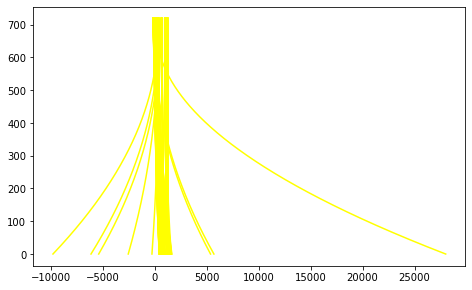

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_Line = Line()
right_Line = Line()

white_output = 'challenge_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [10]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(white_output))